In [1]:
import numpy as np
import pandas as pd
import sklearn.preprocessing
import sklearn.decomposition
import sklearn.cross_decomposition
import sklearn.neighbors
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sn = 1
setnumber = 'FD00' + str(sn)

In [3]:
# read data
print 'read data'
train = pd.read_csv('data/train_'+setnumber+'.csv')
train_RULs = np.array([train.loc[train.id==i, 'cycle'].max() for i in train.id.unique()])
test = pd.read_csv('data/test_'+setnumber+'.csv')
test_RULs = np.array([test.loc[test.id==i, 'RUL'].min() for i in train.id.unique()])
# drop the extra column
print 'drop index column'
train.drop('Unnamed: 0', 1, inplace=True)
test.drop('Unnamed: 0', 1, inplace=True)


read data
drop index column


In [4]:
print 'bin RUL values'
bins = [0, 150, 180, 300, 1000]
#bins = [0, 45, 90, 180, 10000]
status_labels = ['urgent', 'short', 'medium', 'long']
train['status'] = pd.cut(train['RUL'], bins, labels=status_labels)
test['status'] = pd.cut(test['RUL'], bins, labels=status_labels)
print train.status.value_counts()
print test.status.value_counts()

print 'normalize features (using MinMaxScaler)'
train_scalables = train.loc[:,train.columns.difference(['id', 'cycle', 'status'])].values
test_scalables = test.loc[:,test.columns.difference(['id', 'cycle', 'status'])].values

train_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0,1)).fit(train_scalables)
test_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0,1)).fit(test_scalables)

train_values = train_scaler.transform(train_scalables)
test_values = test_scaler.transform(test_scalables)

train.loc[:,train.columns.difference(['id', 'cycle', 'status'])] = train_values
test.loc[:,test.columns.difference(['id', 'cycle', 'status'])] = test_values

bin RUL values
urgent    14924
medium     3021
short      2438
long        148
Name: status, dtype: int64
medium    7085
long      5413
short      557
urgent      41
Name: status, dtype: int64
normalize features (using MinMaxScaler)


In [5]:
print train.columns[1:-2]
print train.columns[-2]
train_X = train.values[:,1:-2]
train_y = train.values[:,-1]
test_X = test.values[:,1:-2]
test_y = test.values[:,-1]


def encode_labels(train_y):
    print 'encode labels as one-vs-all vectors'
    le = sklearn.preprocessing.LabelEncoder()
    le.fit(train_y)
    train_y = le.transform(train_y)

    lb = sklearn.preprocessing.LabelBinarizer()
    lb.fit(train_y)
    train_y = lb.transform(train_y)

    return le, lb, train_y

def transform_label(y, le, lb):
    return lb.transform(le.transform(y))

def invert_transform_label(y, le, lb):
    return le.inverse_transform(lb.inverse_transform(y))

le, lb, train_y = encode_labels(train_y)
test_y = transform_label(test_y, le, lb)


Index([u'cycle', u'setting1', u'setting2', u'setting3', u's1', u's2', u's3',
       u's4', u's5', u's6', u's7', u's8', u's9', u's10', u's11', u's12',
       u's13', u's14', u's15', u's16', u's17', u's18', u's19', u's20', u's21'],
      dtype='object')
RUL
encode labels as one-vs-all vectors


/home/saghar/anaconda2/lib/python2.7/site-packages/numpy/lib/arraysetops.py:216: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag = np.concatenate(([True], aux[1:] != aux[:-1]))
/home/saghar/anaconda2/lib/python2.7/site-packages/numpy/lib/arraysetops.py:275: FutureWarning: numpy equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  return aux[:-1][aux[1:] == aux[:-1]]


[  9.99943722e-01   2.06480610e-05   1.25686755e-05   4.05365751e-06
   3.82350658e-06   3.33103431e-06   1.69439007e-06   1.53999529e-06
   1.40020800e-06   1.31210318e-06] [ 0.99994372  0.99996437  0.99997694  0.99998099  0.99998482  0.99998815
  0.99998984  0.99999138  0.99999278  0.99999409]


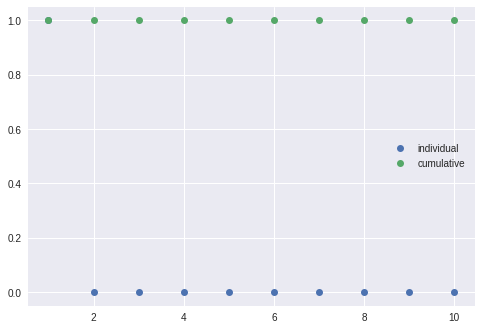

In [6]:
PCA = True
CCA = False
nc=10

if PCA:
    pca = sklearn.decomposition.PCA(n_components=nc)
    pca.fit(train_X)
    trainX = pca.transform(train_X)
    testX = pca.transform(test_X)
    evals = pca.explained_variance_ratio_
    evals_cs = evals.cumsum()
    print evals, evals_cs
    plt.plot(range(1, nc+1), evals, 'o', label='individual')
    plt.plot(range(1, nc+1), evals_cs, 'o', label='cumulative')
    plt.legend()
    plt.show()
elif CCA:
    cca = sklearn.cross_decomposition.CCA(n_components=nc)
    cca.fit(train_X, train_y)
    trainX = cca.transform(train_X)
    testX = cca.transform(test_X)
    

(13096, 11) (20631, 11)
Index([u'comp_1', u'comp_2', u'comp_3', u'comp_4', u'comp_5', u'comp_6',
       u'comp_7', u'comp_8', u'comp_9', u'comp_10', u'status'],
      dtype='object')


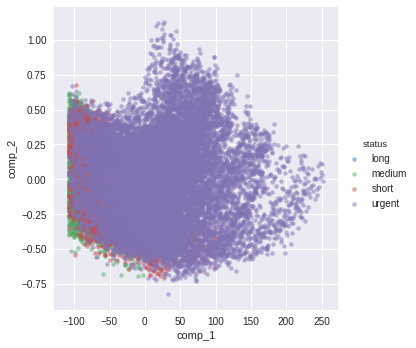

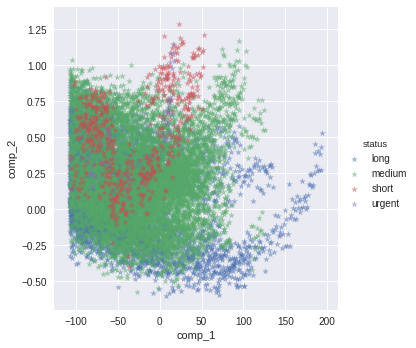

In [7]:
X_train = pd.DataFrame(trainX, columns=['comp_'+str(x) for x in range(1, trainX.shape[1]+1)])
X_train['status'] = train['status']

X_test = pd.DataFrame(testX, columns=['comp_'+str(x) for x in range(1, testX.shape[1]+1)])
X_test['status'] = test['status']

print X_test.shape, X_train.shape
print X_train.columns
sns.lmplot('comp_1', 'comp_2', hue='status', fit_reg=False, data=X_train, markers='o', scatter_kws={'alpha':0.5, 's':20})
sns.lmplot('comp_1', 'comp_2', hue='status', fit_reg=False, data=X_test, markers='*', scatter_kws={'alpha':0.5})
plt.show()


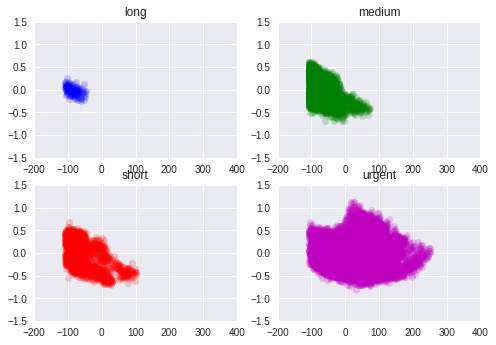

In [9]:
fig, axs = plt.subplots(2,2)
axs = axs.flatten()
axs[0].plot(X_train.loc[X_train.status=='long', 'comp_1'], X_train.loc[X_train.status=='long', 'comp_2'], 'ob', alpha=0.2)
axs[0].set_title('long')
axs[1].plot(X_train.loc[X_train.status=='medium', 'comp_1'], X_train.loc[X_train.status=='medium', 'comp_2'], 'og', alpha=0.2)
axs[1].set_title('medium')
axs[2].plot(X_train.loc[X_train.status=='short', 'comp_1'], X_train.loc[X_train.status=='short', 'comp_2'], 'or', alpha=0.2)
axs[2].set_title('short')
axs[3].plot(X_train.loc[X_train.status=='urgent', 'comp_1'], X_train.loc[X_train.status=='urgent', 'comp_2'], 'om', alpha=0.2)
axs[3].set_title('urgent')
for i in range(4):
    axs[i].set_xlim(-200, 400)
    axs[i].set_ylim(-1.5, 1.5)
plt.show()

In [12]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import AdaBoostClassifier
classifier = OneVsRestClassifier(AdaBoostClassifier())
classifier.fit(trainX, train_y)

OneVsRestClassifier(estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None),
          n_jobs=1)

In [25]:
y_pred = np.array(classifier.predict(testX))
print test_y
print y_pred

[[0 0 0 1 0]
 [0 0 0 1 0]
 [0 0 0 1 0]
 ..., 
 [0 0 1 0 0]
 [0 0 1 0 0]
 [0 0 1 0 0]]
[[0 0 1 0 0]
 [0 0 1 0 0]
 [0 0 0 0 0]
 ..., 
 [0 0 0 0 1]
 [0 0 0 0 1]
 [0 0 0 0 1]]


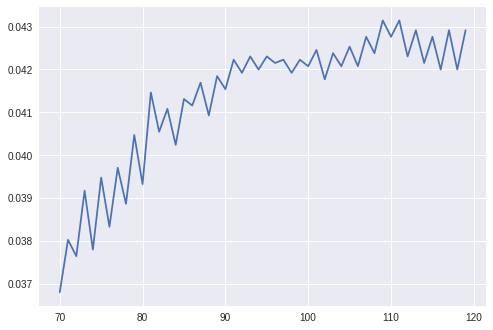

In [9]:
ns = range(70, 120)
scores = np.array([])
for n_neighbors in ns:
    neigh = sklearn.neighbors.KNeighborsClassifier(n_neighbors=n_neighbors)
    neigh.fit(trainX, train_y)
    pred_y = neigh.predict(testX)
    y_proba = neigh.predict_proba(testX)
    
    #print n_neighbors, neigh.score(testX, test_y)
    scores = np.append(scores, neigh.score(testX, test_y))
plt.plot(ns, scores, '-')
plt.show()

In [35]:
import sklearn.metrics
neigh.predict_proba(testX)[4].shape
#fpr, tpr, thresholds = sklearn.metrics.roc_curve(test_y, neigh.predict_proba(testX))

(13096, 2)

In [10]:
y_p = invert_transform_label(pred_y, le, lb)
y_test = invert_transform_label(test_y, le, lb)
X_test['prediction'] = y_p
print X_test.status.value_counts()
print X_test.prediction.value_counts()

medium    7085
long      5413
short      557
urgent      41
Name: status, dtype: int64
urgent    8546
medium    1410
Name: prediction, dtype: int64


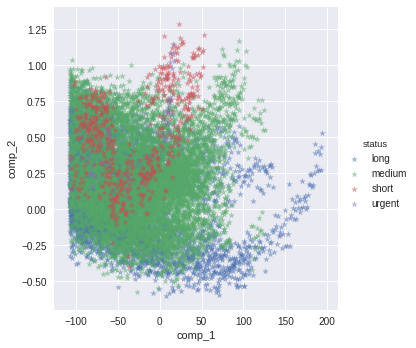

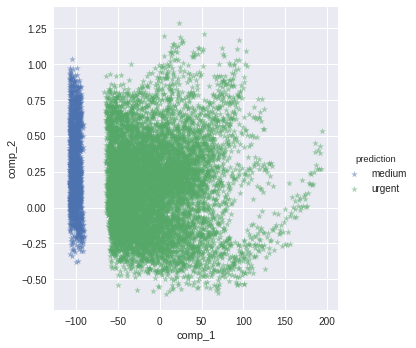

In [11]:
sns.lmplot('comp_1', 'comp_2', hue='status', fit_reg=False, data=X_test, markers='*', scatter_kws={'alpha':0.5})
sns.lmplot('comp_1', 'comp_2', hue='prediction', fit_reg=False, data=X_test, markers='*', scatter_kws={'alpha':0.5})
plt.show()

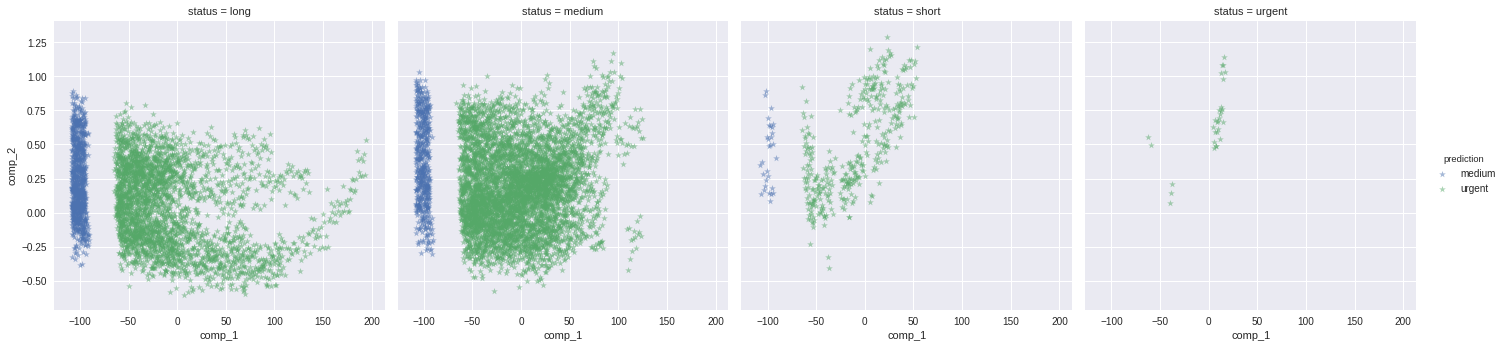

In [12]:
sns.lmplot('comp_1', 'comp_2', hue='prediction', col='status', fit_reg=False, data=X_test, markers='*', scatter_kws={'alpha':0.5})
plt.show()

In [13]:
import sklearn.svm
clf = sklearn.svm.SVC()
clf.fit(trainX, train_y)

ValueError: bad input shape (20631, 5)

In [23]:
range(1, 30, 3)

[1, 4, 7, 10, 13, 16, 19, 22, 25, 28]

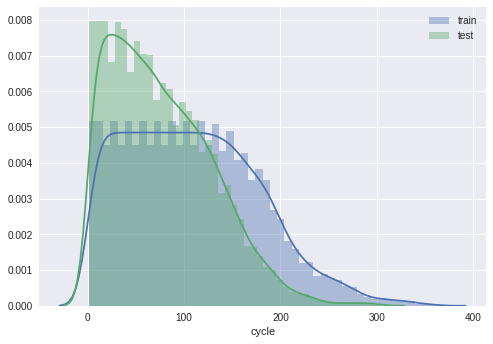

303 1.0
362 1.0


In [21]:
sns.distplot(train.cycle, label='train')
sns.distplot(test.cycle, label='test')
plt.legend()
plt.show()
print test.cycle.max(), test.RUL.max()
print train.cycle.max(), train.RUL.max()